In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0, '/content/drive/My Drive/Step 4')

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from utils import display_prediction, decode_segmap
from Cityscapes import Cityscapes
from gta5 import GTA5
from bisenetv2 import BiSeNetV2

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {DEVICE}')

NUM_CLASSES = 19    

BATCH_SIZE = 8       # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20       # Total number of training epochs (iterations over dataset)
STEP_SIZE = 25        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1           # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 30

RESIZED_H = 512
RESIZED_W = 1024

MODE = 'LOAD_AND_TRAIN'       #TRAIN or LOAD_AND_TRAIN or LOAD
MODEL_PATH = '/content/drive/My Drive/Step 4/step4_FDA_partB_L0.01.tar' #File to save the model in

Running on cpu


In [6]:
import numpy as np
import random
from PIL import Image
import cv2
from tqdm import tqdm

class StyleAugment:
    def __init__(self, n_images_per_style=10, L=0.1, size=(1024, 512), b=None):
        self.styles = []
        self.styles_names = []
        self.n_images_per_style = n_images_per_style
        self.L = L
        self.size = size
        self.sizes = None
        self.cv2 = False
        self.b = b

    def preprocess(self, x):
        if isinstance(x, np.ndarray):
            x = cv2.resize(x, self.size, interpolation=cv2.INTER_CUBIC)
            self.cv2 = True
        else:
            x = x.resize(self.size, Image.BICUBIC)
        x = np.asarray(x, np.float32)
        x = x[:, :, ::-1]
        x = x.transpose((2, 0, 1))
        return x.copy()

    def deprocess(self, x, size):
        if self.cv2:
            x = cv2.resize(np.uint8(x).transpose((1, 2, 0))[:, :, ::-1], size, interpolation=cv2.INTER_CUBIC)
        else:
            x = Image.fromarray(np.uint8(x).transpose((1, 2, 0))[:, :, ::-1])
            x = x.resize(size, Image.BICUBIC)
        return x

    def add_style(self, loader, multiple_styles=False, name=None):
        if self.n_images_per_style < 0:
            return

        if name is not None:
            self.styles_names.append([name] * self.n_images_per_style if multiple_styles else [name])

        loader.return_unprocessed_image = True
        n = 0
        styles = []

        for sample in tqdm(loader):
            image = self.preprocess(sample)

            if n >= self.n_images_per_style:
                break
            styles.append(self._extract_style(image))
            n += 1

        if self.n_images_per_style > 1:
            if multiple_styles:
                self.styles += styles
            else:
                styles = np.stack(styles, axis=0)
                style = np.mean(styles, axis=0)
                self.styles.append(style)
        elif self.n_images_per_style == 1:
            self.styles += styles

        loader.return_unprocessed_image = False

    def _extract_style(self, img_np):
        fft_np = np.fft.fft2(img_np, axes=(-2, -1))
        amp = np.abs(fft_np)
        amp_shift = np.fft.fftshift(amp, axes=(-2, -1))
        if self.sizes is None:
            self.sizes = self.compute_size(amp_shift)
        h1, h2, w1, w2 = self.sizes
        style = amp_shift[:, h1:h2, w1:w2]
        return style

    def compute_size(self, amp_shift):
        _, h, w = amp_shift.shape
        b = (np.floor(np.amin((h, w)) * self.L)).astype(int) if self.b is None else self.b
        c_h = np.floor(h / 2.0).astype(int)
        c_w = np.floor(w / 2.0).astype(int)
        h1 = c_h - b
        h2 = c_h + b + 1
        w1 = c_w - b
        w2 = c_w + b + 1
        return h1, h2, w1, w2

    def apply_style(self, image):
        return self._apply_style(image)

    def _apply_style(self, img):

        if self.n_images_per_style < 0:
            return img

        if len(self.styles) > 0:
            n = random.randint(0, len(self.styles) - 1)
            style = self.styles[n]
        else:
            style = self.styles[0]

        if isinstance(img, np.ndarray):
            H, W = img.shape[0:2]
        else:
            W, H = img.size
        img_np = self.preprocess(img)

        fft_np = np.fft.fft2(img_np, axes=(-2, -1))
        amp, pha = np.abs(fft_np), np.angle(fft_np)
        amp_shift = np.fft.fftshift(amp, axes=(-2, -1))
        h1, h2, w1, w2 = self.sizes
        amp_shift[:, h1:h2, w1:w2] = style
        amp_ = np.fft.ifftshift(amp_shift, axes=(-2, -1))

        fft_ = amp_ * np.exp(1j * pha)
        img_np_ = np.fft.ifft2(fft_, axes=(-2, -1))
        img_np_ = np.real(img_np_)
        img_np__ = np.clip(np.round(img_np_), 0., 255.)

        img_with_style = self.deprocess(img_np__, (W, H))

        return img_with_style

    def test(self, images_np, images_target_np=None, size=None):
        Image.fromarray(np.uint8(images_np.transpose((1, 2, 0)))[:, :, ::-1]).show()
        fft_np = np.fft.fft2(images_np, axes=(-2, -1))
        amp = np.abs(fft_np)
        amp_shift = np.fft.fftshift(amp, axes=(-2, -1))
        h1, h2, w1, w2 = self.sizes
        style = amp_shift[:, h1:h2, w1:w2]

        fft_np_ = np.fft.fft2(images_np if images_target_np is None else images_target_np, axes=(-2, -1))
        amp_, pha_ = np.abs(fft_np_), np.angle(fft_np_)
        amp_shift_ = np.fft.fftshift(amp_, axes=(-2, -1))
        h1, h2, w1, w2 = self.sizes
        amp_shift_[:, h1:h2, w1:w2] = style
        amp__ = np.fft.ifftshift(amp_shift_, axes=(-2, -1))

        fft_ = amp__ * np.exp(1j * pha_)
        img_np_ = np.fft.ifft2(fft_, axes=(-2, -1))
        img_np_ = np.real(img_np_)
        img_np__ = np.clip(np.round(img_np_), 0., 255.)
        Image.fromarray(np.uint8(images_target_np.transpose((1, 2, 0)))[:, :, ::-1]).show()
        Image.fromarray(np.uint8(img_np__).transpose((1, 2, 0))[:, :, ::-1]).show()

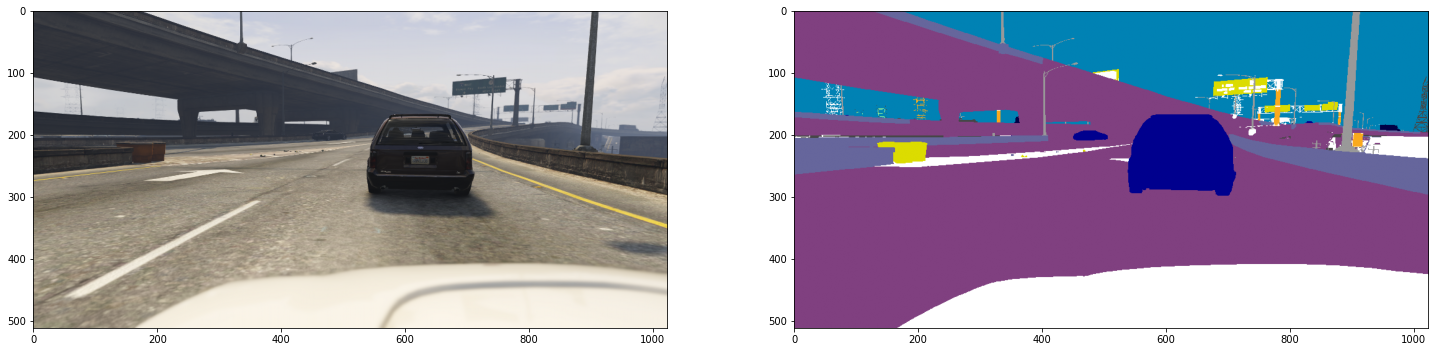

In [7]:
mean = [0.3257, 0.3690, 0.3223]
std = [0.2112, 0.2148, 0.2115]
normalizer = transforms.Normalize(mean=mean, std=std)
resizer_bicubic = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.BICUBIC)
resizer_nearest = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.NEAREST)

train_transform = transforms.Compose([resizer_bicubic])
eval_transform = transforms.Compose([resizer_bicubic])
target_transform = transforms.Compose([resizer_nearest])

train_dataset_CS = Cityscapes('drive/MyDrive/', partition_type=('B', 'heterogeneous'), split='train', transform=train_transform, target_transform=target_transform)
test_dataset_CS = Cityscapes('drive/MyDrive/', partition_type=('B', 'heterogeneous'), split='val', transform=eval_transform, target_transform=target_transform)
train_dataset_GTA5 = GTA5('drive/MyDrive/', transform=train_transform, target_transform=target_transform)

train_dataset_GTA5.return_PIL = False
i, l = train_dataset_GTA5.__getitem__(20)
fig = plt.figure(figsize=(25, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(i.permute(1, 2, 0))
fig.add_subplot(1, 2, 2)
l = decode_segmap(l.squeeze())
plt.imshow(l)
plt.show()

In [14]:
import random
#STYLE EXTRACTION
#Creates a style from each client
styles = StyleAugment(L=0.0001, b=None)
num_clients = train_dataset_CS.get_num_clients()
for i in random.sample(range(num_clients), 1):
    train_dataset_CS.set_client(i)
    train_dataset_CS.return_PIL = True
    styles.add_style(train_dataset_CS)
train_dataset_GTA5.set_styles(styles)
i, _ = train_dataset_GTA5.__getitem__(15)
plt.imshow(i.permute(1, 2, 0))

 83%|████████▎ | 10/12 [00:05<00:01,  1.93it/s]


TypeError: ignored

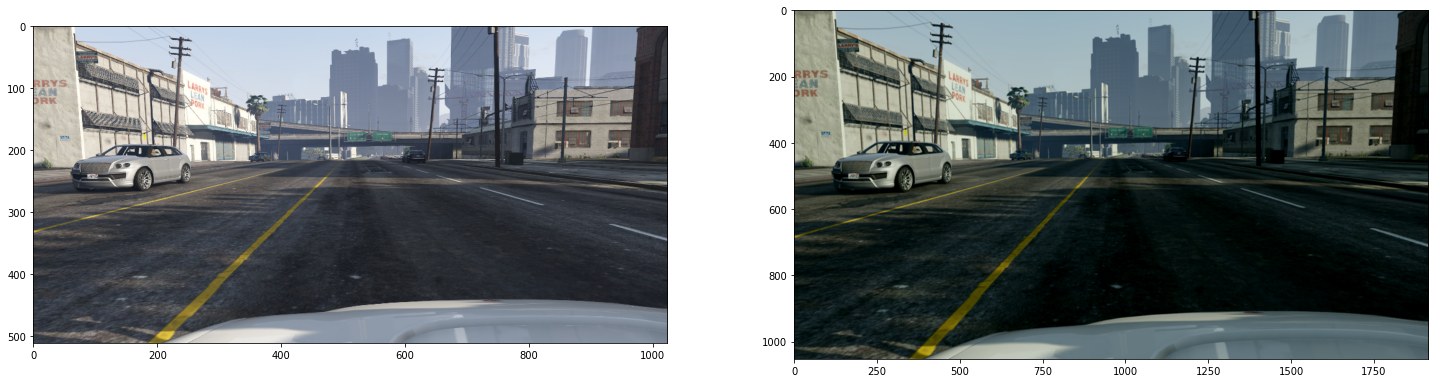

In [15]:
#STYLE TEST
train_dataset_GTA5.return_PIL = False
i, _ = train_dataset_GTA5.__getitem__(15)
fig = plt.figure(figsize=(25, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(i.permute(1, 2, 0))
fig.add_subplot(1, 2, 2)
train_dataset_GTA5.return_PIL = True
i = train_dataset_GTA5.__getitem__(15)
i = styles.apply_style(i)
plt.imshow(i)

In [ ]:
train_dataloader = DataLoader(train_dataset_GTA5, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(test_dataset_CS, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
net = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=False)
net = net.to(DEVICE)

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss(ignore_index=255) # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of the net
# (nn.Module objects implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=255).to(DEVICE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def train_epoch(net, dataloader, lr=0.01, optimizer=optimizer, loss_fn=criterion):
  net.train()

  total_loss, miou, count = 0, 0, 0
  for i, (images, masks) in enumerate(dataloader):
    images = images.to(DEVICE, dtype=torch.float32)
    masks = masks.squeeze().to(DEVICE, dtype=torch.long)
    optimizer.zero_grad()

    out = net(images)
    loss = loss_fn(out, masks) 
    loss.backward()
    optimizer.step()

    total_loss += loss
    miou += metric(out, masks)
    count += 1
    if i%LOG_FREQUENCY == 0:
      print("  minibatch {}: train mIoU = {} train loss = {}".format(i, miou.item()/count, total_loss.item()/count))
  return total_loss.item()/count, miou.item()/count

def validate(net, dataloader, loss_fn=criterion):
  net.eval()
  loss, miou, count = 0, 0, 0
  with torch.no_grad():
    for images, masks in dataloader:
      images = images.to(DEVICE)
      masks = masks.squeeze().to(DEVICE)

      out = net(images)
      loss += loss_fn(out, masks) 
      miou += metric(out, masks)
      count += 1
  return loss.item()/count, miou.item()/count

def train(net, train_loader, test_loader, history=None, starting_epoch=0, optimizer=optimizer, lr=0.01, epochs=10, loss_fn=criterion):
  history = history or {'train_loss' : [0.0], 'train_miou': [0.0], 'val_loss': [0.0], 'val_miou': [0.0]} 

  print(f'Lr: {lr}\nBatch size: {BATCH_SIZE}\nEpochs: {epochs}\nLoss function: {loss_fn}\nOptimizer: {optimizer}')

  for ep in range(starting_epoch, starting_epoch+epochs):
    print(f'----------- EPOCH {ep+1} -----------')
    train_loss, train_miou = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
    val_loss, val_miou = validate(net, test_loader, loss_fn=loss_fn)
    print(f"Train mIoU={train_miou:.3f}, Val mIoU={val_miou:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")

    save = False
    if val_miou > max(history['val_miou']): #If this is the best validation mIoU, save the model
      save = True
      print(f'** Saving model with mIoU = {val_miou}')

    history['train_loss'].append(train_loss)
    history['train_miou'].append(train_miou)
    history['val_loss'].append(val_loss)
    history['val_miou'].append(val_miou)
    display_prediction(net, test_dataset_CS, random=False)
    scheduler.step()

    if save == True:
      torch.save({
            'model_state_dict': net.state_dict(),
            'optim_state_dict': optimizer.state_dict(),
            'epoch': ep,
            'history': history,
            'batch_size': BATCH_SIZE,
            'lr': lr,
            'resized_height': RESIZED_H,
            'resized_width': RESIZED_W,
        }, MODEL_PATH)

  return history

def plot_history(history):
  plt.figure(figsize=(15,5))
  plt.subplot(121)
  plt.plot(history['train_miou'][1:], label='Training mIoU')
  plt.plot(history['val_miou'][1:], label='Validation mIoU')
  plt.legend()
  plt.subplot(122)
  plt.plot(history['train_loss'][1:], label='Training loss')
  plt.plot(history['val_loss'][1:], label='Validation loss')
  plt.legend()

Loading pre-trained model at epoch 18, mIoU=0.1744311898946762
Loaded pre-trained model at epoch 18
Lr: 0.05
Batch size: 8
Epochs: 20
Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.05
    lr: 0.05
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 5e-05
)
----------- EPOCH 19 -----------
  minibatch 0: train mIoU = 0.2522816061973572 train loss = 0.5427756905555725
  minibatch 30: train mIoU = 0.2398647339113297 train loss = 0.6548364085535849
  minibatch 60: train mIoU = 0.23382626205194193 train loss = 0.6659236345134798
Train mIoU=0.234, Val mIoU=0.166, Train loss=0.663, Val loss=1.018


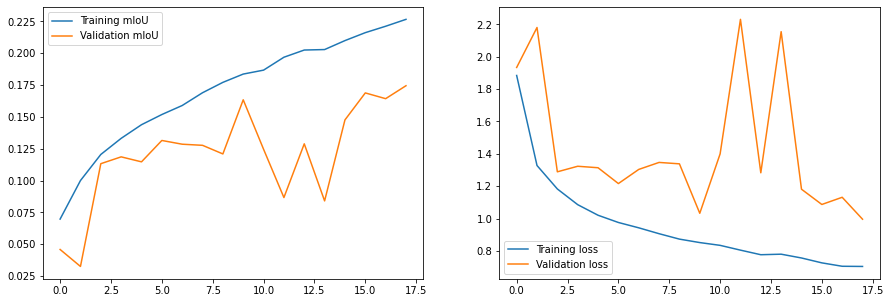

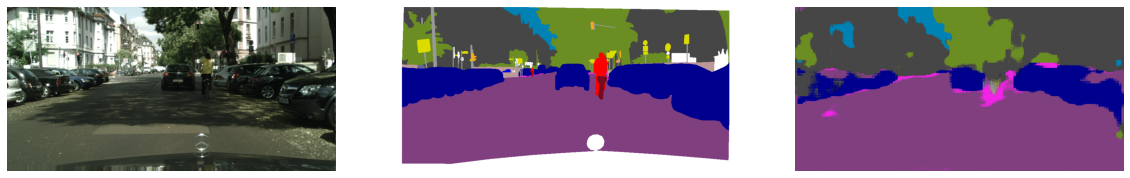

----------- EPOCH 20 -----------
  minibatch 0: train mIoU = 0.20429034531116486 train loss = 0.8516832590103149
  minibatch 30: train mIoU = 0.23455876688803395 train loss = 0.6916630037369267
  minibatch 60: train mIoU = 0.23839050042824667 train loss = 0.6508653359334977
Train mIoU=0.238, Val mIoU=0.156, Train loss=0.655, Val loss=1.200


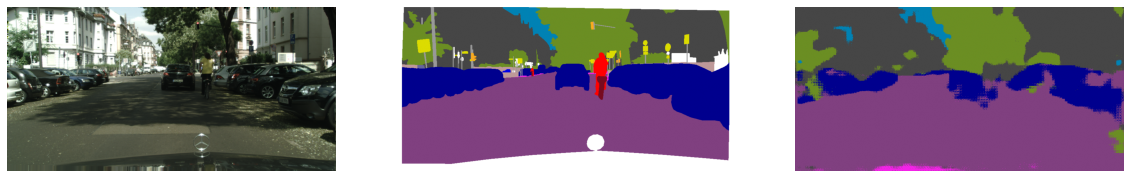

----------- EPOCH 21 -----------
  minibatch 0: train mIoU = 0.2588922083377838 train loss = 0.6676938533782959
  minibatch 30: train mIoU = 0.2487597773152013 train loss = 0.6300118969332787
  minibatch 60: train mIoU = 0.24343928352731173 train loss = 0.646056878762167
Train mIoU=0.244, Val mIoU=0.168, Train loss=0.645, Val loss=1.048


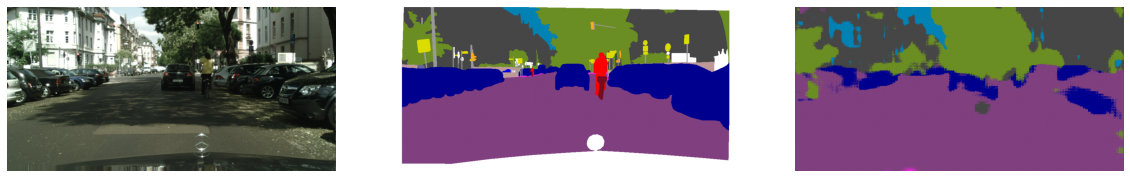

----------- EPOCH 22 -----------
  minibatch 0: train mIoU = 0.21975886821746826 train loss = 0.7752407789230347
  minibatch 30: train mIoU = 0.24718773749566847 train loss = 0.6515866556475239


In [ ]:
def load_model(path):
  checkpoint = torch.load(MODEL_PATH)
  net.load_state_dict(checkpoint['model_state_dict'])
  #optimizer.load_state_dict(checkpoint['optim_state_dict'])
  epoch = checkpoint['epoch'] + 1
  history = checkpoint['history']
  mIoU = history['val_miou'][-1]
  print(f'Loading pre-trained model at epoch {epoch}, mIoU={mIoU}')
  plot_history(history)
  return epoch, history

train_dataset_GTA5.return_PIL = False
test_dataset_CS.return_PIL = False

if MODE == 'LOAD':
  epoch, history = load_model(MODEL_PATH)
  net.eval()
elif MODE == 'LOAD_AND_TRAIN':
  epoch, history = load_model(MODEL_PATH)
  print(f'Loaded pre-trained model at epoch {epoch}')
  history = train(net, train_dataloader, val_dataloader, history, starting_epoch=epoch, optimizer=optimizer, lr=LR, epochs=NUM_EPOCHS)
  plot_history(history)
elif MODE == 'TRAIN':
  history = train(net, train_dataloader, val_dataloader, history=None, starting_epoch=0, optimizer=optimizer, lr=LR, epochs=NUM_EPOCHS)
  plot_history(history)

In [ ]:
display_prediction(net, train_dataset_GTA5, random=True)